In [23]:
import warnings
warnings.filterwarnings("ignore")
import os
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

In [2]:
RANDOM_STATE = 42
DATA_PATH = "dataset.xlsx"
MODEL_PATH = "model.pkl"
TEST_SIZE = 0.2

In [4]:
def simple_word_tokenize(s: str):
    return re.findall(r"[A-Za-zÀ-ÖØ-öø-ÿ0-9_]+", str(s).lower())

def plot_label_distribution(y_series: pd.Series, title_suffix=""):
    y_series = y_series.dropna()
    nunique = y_series.nunique()
    plt.figure(figsize=(7, 4))

    if pd.api.types.is_numeric_dtype(y_series) and nunique > 20:
        plt.hist(y_series, bins=30, edgecolor='black', color='skyblue')
        plt.title(f"Distribusi Target (Numerik){title_suffix}")
        plt.xlabel("Nilai Target")
        plt.ylabel("Frekuensi")
        plt.tight_layout()
        plt.show()
    else:
        vc = y_series.value_counts().head(30)
        vc.plot(kind='bar')
        plt.title(f"Distribusi Target (Kategorikal){title_suffix}")
        plt.xlabel("Kelas")
        plt.ylabel("Jumlah")
        plt.tight_layout()
        plt.show()

In [5]:
#Load Data

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Tidak menemukan file {DATA_PATH}. Pastikan file ada di folder yang sama.")

df = pd.read_excel(DATA_PATH)

Pembersihan Data

In [21]:
df.columns = (df.columns.astype(str)
              .str.replace('\xa0', ' ')
              .str.strip())

In [25]:
df = df.drop(columns=['NO'], errors='ignore')

Missing Value & Outlier Capping

In [26]:
required_num = ['HARGA','LB','LT','KT','KM','GRS']
missing_req = [c for c in required_num if c not in df.columns]
if missing_req:
    raise KeyError(f"Kolom wajib hilang: {missing_req}. Dataset butuh {required_num}.")

for c in required_num:
    df[c] = pd.to_numeric(df[c], errors='coerce')

num_imputer = SimpleImputer(strategy='median')
df[required_num] = num_imputer.fit_transform(df[required_num])

In [27]:
for c in ['LB','LT','KT','KM','GRS']:
    q1, q3 = df[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    df[c] = df[c].clip(lower=low, upper=high)

In [28]:
df['LB_LT'] = df['LB'] / df['LT']
df['TOTAL_KAMAR'] = df['KT'] + df['KM']
df['LB_KT'] = df['LB'] * df['KT']

X = df[['LB','LT','KT','KM','GRS','LB_LT','TOTAL_KAMAR','LB_KT']]
y_log = np.log(df['HARGA'])
y_orig = df['HARGA'].copy()

Training / Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [33]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf_random = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_random.fit(X_train, y_train)
best_model = rf_random.best_estimator_

In [13]:
joblib.dump(best_model, MODEL_PATH)

['model.pkl']

In [31]:
print(type(best_model).__name__)
try:
    print("Best Params:", rf_random.best_params_)
except Exception:
    pass

RandomForestRegressor
Best Params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}


In [32]:
y_pred_log = best_model.predict(X_test)
y_pred = np.exp(y_pred_log)
y_test_orig = np.exp(y_test)

r2 = r2_score(y_test_orig, y_pred)
mae = mean_absolute_error(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))

print("Random Forest dengan Log-Transform & Tuning\n")
print(f"Akurasi (R²): {r2*100:.2f}%")
print(f"MAE: Rp{mae:,.0f}")
print(f"RMSE: Rp{rmse:,.0f}")
print(f"Model tersimpan ke: {MODEL_PATH}")

Random Forest dengan Log-Transform & Tuning

Akurasi (R²): 82.32%
MAE: Rp1,634,698,348
RMSE: Rp2,873,146,714
Model tersimpan ke: model.pkl


#**EDA**

A. Distribusi label/kelas

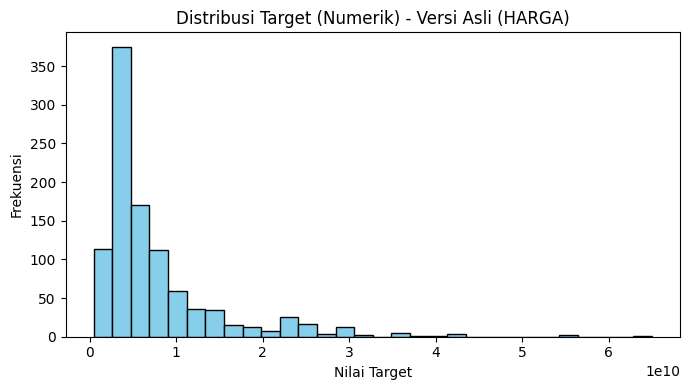

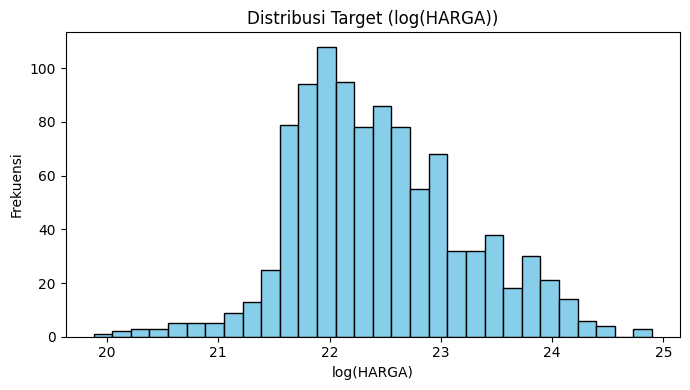

In [15]:
plot_label_distribution(y_orig, title_suffix=" - Versi Asli (HARGA)")

plt.figure(figsize=(7,4))
plt.hist(np.log(y_orig), bins=30, edgecolor='black', color='skyblue')
plt.title("Distribusi Target (log(HARGA))")
plt.xlabel("log(HARGA)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

B. Word Count

In [16]:
text_cols = [c for c in df.columns if df[c].dtype == 'object']
if len(text_cols) == 0:
    print("Tidak ada kolom bertipe teks. Langkah (b) di-skip.")
else:
    print(f"Kolom teks terdeteksi: {text_cols}")
    for col in text_cols:
        words = []
        for val in df[col].dropna():
            words.extend(simple_word_tokenize(val))
        counter = Counter(words)
        top_20 = counter.most_common(20)
        print(f"\nTop 20 kata paling sering di kolom '{col}':")
        for w, cnt in top_20:
            print(f"{w:20s} : {cnt}")

Kolom teks terdeteksi: ['NAMA RUMAH']

Top 20 kata paling sering di kolom 'NAMA RUMAH':
tebet                : 1050
rumah                : 902
di                   : 510
jakarta              : 443
selatan              : 398
dijual               : 256
huni                 : 229
siap                 : 217
jalan                : 188
mobil                : 144
2                    : 132
baru                 : 127
strategis            : 123
timur                : 121
lokasi               : 118
barat                : 110
dalam                : 98
dekat                : 97
mewah                : 86
bagus                : 77


C. Histogram fitur numerik

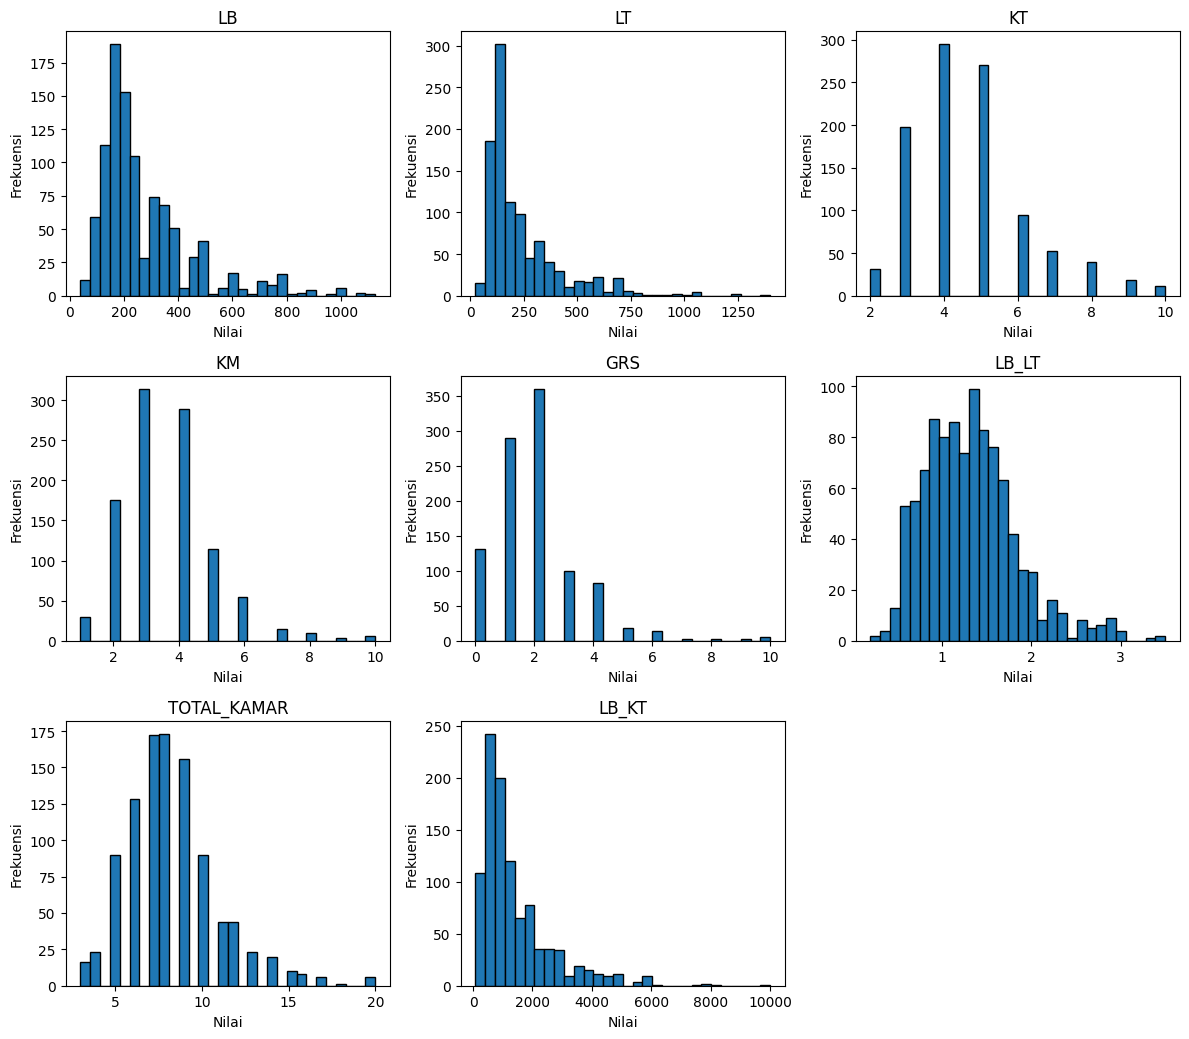

In [17]:
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
if len(numeric_cols) == 0:
    print("Tidak ada fitur numerik untuk dibuat histogram.")
else:
    n = len(numeric_cols)
    cols = 3
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols * 4, rows * 3.5))
    for i, col in enumerate(numeric_cols, start=1):
        plt.subplot(rows, cols, i)
        plt.hist(X[col].dropna(), bins=30, edgecolor='black')
        plt.title(col)
        plt.xlabel("Nilai")
        plt.ylabel("Frekuensi")
    plt.tight_layout()
    plt.show()

D. Korelasi antar fitur

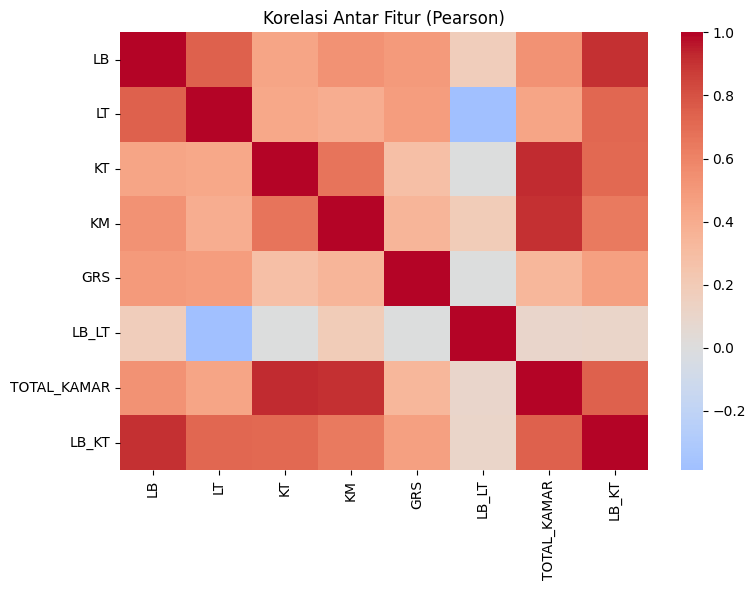

In [19]:
import seaborn as sns

corr = df[numeric_cols].corr(method='pearson')
_HAS_SEABORN = True
if _HAS_SEABORN:
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title("Korelasi Antar Fitur (Pearson)")
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr, interpolation='nearest', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(im)
    plt.title("Korelasi Antar Fitur (Pearson)")
    tick_pos = np.arange(len(numeric_cols))
    plt.xticks(tick_pos, numeric_cols, rotation=90)
    plt.yticks(tick_pos, numeric_cols)
    plt.tight_layout()
    plt.show()

E. Contoh sample data

In [20]:
try:
    from IPython.display import display
    display(df.sample(5, random_state=RANDOM_STATE))
    print("\n Ringkasan Statistik di Fitur Numerik")
    display(df[numeric_cols].describe().T)
except Exception:
    print(df.sample(5, random_state=RANDOM_STATE).to_string(index=False))
    print("\nRingkasan Statistik di Fitur Numerik")
    print(df[numeric_cols].describe().T.to_string())

,NAMA RUMAH,HARGA,LB,LT,KT,KM,GRS,LB_LT,TOTAL_KAMAR,LB_KT
629,Rumah Bagus Siap Huni JUAL CEPAT ! Tebet Utara,8.900000e+09,300.0,300.0,5.0,4.0,2.0,1.000000,9.0,1500.0
788,"Dijual Rumah, Siap Huni,Strategis, Di Tebet Ja...",6.500000e+09,148.0,150.0,4.0,3.0,3.0,0.986667,7.0,592.0
684,Rumah Cantik Minimalis Di Tebet,6.500000e+09,300.0,200.0,5.0,4.0,4.0,1.500000,9.0,1500.0
516,"For Sale British Tuscan House At Tebet Mas, Ja...",3.700000e+10,500.0,720.0,5.0,5.0,2.0,0.694444,10.0,2500.0
529,Dijual Rumah Tebet Raya Lokasi Premium Area Ko...,1.850000e+10,300.0,520.0,4.0,3.0,3.0,0.576923,7.0,1200.0



 Ringkasan Statistik di Fitur Numerik


,count,mean,std,min,25%,50%,75%,max
LB,1010.0,276.539604,177.864557,40.00000,150.000000,216.500000,350.00,1126.0
LT,1010.0,237.432673,179.957604,25.00000,130.000000,165.000000,290.00,1400.0
KT,1010.0,4.668317,1.572776,2.00000,4.000000,4.000000,5.00,10.0
KM,1010.0,3.607921,1.420066,1.00000,3.000000,3.000000,4.00,10.0
GRS,1010.0,1.920792,1.510998,0.00000,1.000000,2.000000,2.00,10.0
LB_LT,1010.0,1.315530,0.514724,0.20429,0.931858,1.276891,1.60,3.5
TOTAL_KAMAR,1010.0,8.276238,2.735069,3.00000,6.000000,8.000000,9.00,20.0
LB_KT,1010.0,1414.938614,1245.473453,80.00000,600.000000,1000.000000,1793.75,10000.0


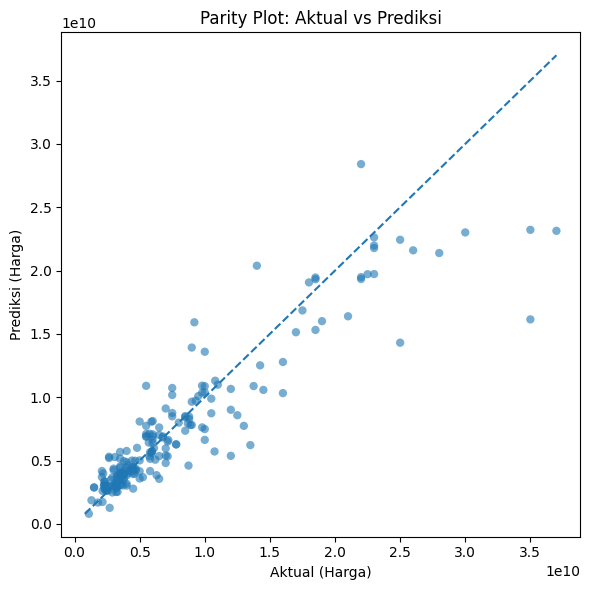

In [34]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_orig, y_pred, alpha=0.6, edgecolors='none')
min_v = float(np.min([y_test_orig.min(), y_pred.min()]))
max_v = float(np.max([y_test_orig.max(), y_pred.max()]))
plt.plot([min_v, max_v], [min_v, max_v], linestyle='--')  # garis 45°
plt.xlabel("Aktual (Harga)"); plt.ylabel("Prediksi (Harga)")
plt.title("Parity Plot: Aktual vs Prediksi")
plt.tight_layout(); plt.show()

In [35]:
residuals = y_test_orig - y_pred

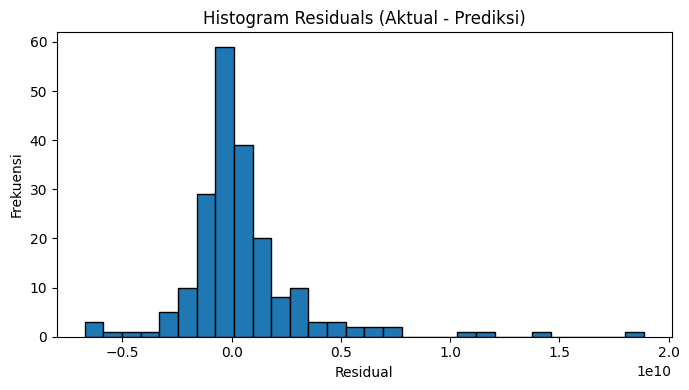

In [36]:
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Histogram Residuals (Aktual - Prediksi)")
plt.xlabel("Residual"); plt.ylabel("Frekuensi")
plt.tight_layout(); plt.show()

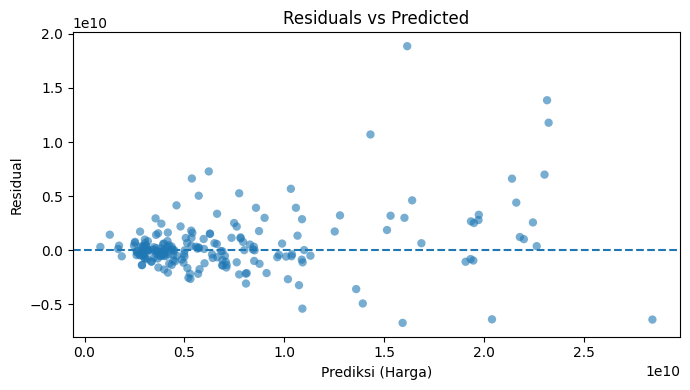

In [37]:
plt.figure(figsize=(7,4))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='none')
plt.axhline(0, linestyle='--')
plt.xlabel("Prediksi (Harga)"); plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout(); plt.show()

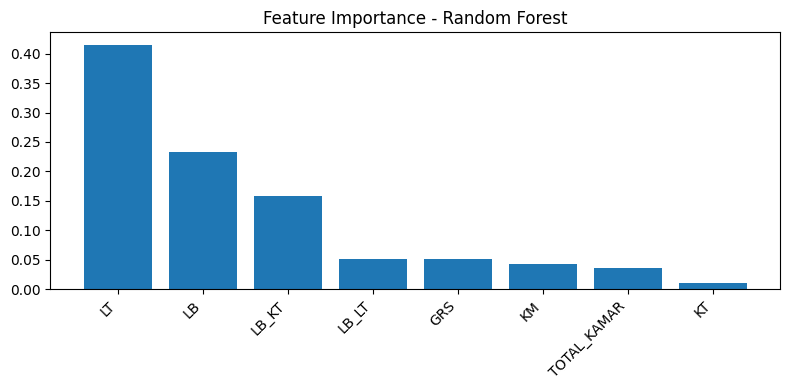

In [38]:
importances = getattr(best_model, "feature_importances_", None)
if importances is not None:
    feat_names = X.columns.tolist()
    order = np.argsort(importances)[::-1]
    plt.figure(figsize=(8,4))
    plt.bar(range(len(feat_names)), importances[order])
    plt.xticks(range(len(feat_names)), [feat_names[i] for i in order], rotation=45, ha='right')
    plt.title("Feature Importance - Random Forest")
    plt.tight_layout(); plt.show()
else:
    print("Model tidak menyediakan feature_importances_.")